## Get Packages

In [15]:
import pandas as pd
import numpy as np
import sys
import itertools
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

In [6]:
from importlib import reload
import mab
reload(mab)

mab.mab_test()

Good - Abraham


## Create Synthetic Segment

In [7]:
row_count = 100000
seg_cols = ['gender', 'age',
            'income', 'buyer', 
            'region', 'area',
            'parent']

segments = ["Male", "Female",
            "Young", "Middle Age", "Older",
            "Low Income", "Medium Income", "High Income",
            "Prior Buyer", "First-Time Buyer",
            "North", "West", "South", "East",
            "Urban", "Suburban",
            "Non-Parent", "Parent"]

combo_weights = mab.create_all_combo_weights()

Segment_df = mab.create_synthetic_sample(row_count=row_count)

combo_weights.groupby('variant_assignment').aggregate({'combos_weights': ['mean', 'count', 'std']})

combos_weights                
                             mean count       std
variant_assignment                               
Control                  0.031052   576  0.023211
Variant A                0.146741   576  0.053947
Variant B                0.148835   576  0.050833
Variant C                0.149177   576  0.057761

## Create Outcome Metric

In [4]:
############
## Step 1 ##
############

## Full random assignment for Variant
Segment_df = mab.add_conversion_rates(df=Segment_df, seg_cols=seg_cols, 
                                      segments=segments,all_combos_weights=combo_weights,
                                      print_diagnostics=True)

converted              
                  mean  count    sum
was_modified                        
False         0.039394   3960    156
True          0.214963  96040  20645

In [ ]:
#############
## Step #2 ##
#############

# Take the Target group and build an optimization score to determine how ads should be allocated
Segment_df.loc[Segment_df['variant_assignment'] == 'Variant A', 'Variant_a_performance'] = Segment_df['converted']
Segment_df.loc[Segment_df['variant_assignment'] == 'Variant B', 'Variant_b_performance'] = Segment_df['converted']
Segment_df.loc[Segment_df['variant_assignment'] == 'Variant C', 'Variant_c_performance'] = Segment_df['converted']

## Performance Scores all interactions
perf_scores_all_interactions = Segment_df.groupby(seg_cols).agg({'Variant_a_performance': ['mean'],
                                                                 'Variant_b_performance': ['mean'],
                                                                 'Variant_c_performance': ['mean']}).reset_index().droplevel(1, axis = 1)

In [ ]:
###################
## Next Audience ##
###################
Segment_df_step2 = mab.create_synthetic_sample(300000)

Segment_df_step2 = mab.assignment_with_optimization(df = Segment_df_step2, prior_performance_scores=perf_scores_all_interactions, 
                                                    seg_cols=seg_cols,method='max', opt_target_size=0.20, learning_weight=2)

In [ ]:
## Create performance score
Segment_df_step2 = mab.add_conversion_rates(df=Segment_df_step2, seg_cols=seg_cols, segments=segments,
                                            all_combos_weights=combo_weights, print_diagnostics=True, 
                                            assign_variant=False)

Segment_df_step2.groupby(['target_control','core_membership'], dropna=False).aggregate({'converted': ['min', 'mean','max', 'count', 'std']})

In [12]:
###############################
## Let's turn it into a loop ##
###############################

## Let's do 50 Loops, each time increasing the optimized target sample by 1
overall_performance = []
overall_target_performance = []
org_target_performance = []
opt_target_performance = []

steps = 75
row_count = 200000

for i in range(steps):

    if i == 0:
        
        Segment_df = mab.create_synthetic_sample(row_count=row_count)        
        Segment_df = mab.add_conversion_rates(df=Segment_df, seg_cols=seg_cols, segments=segments, all_combos_weights=combo_weights, print_diagnostics=False)

        ## Store results
        overall_performance.append(Segment_df['converted'].mean())
        org_target_performance.append(Segment_df.loc[Segment_df['variant_assignment'] != 'Control', 'converted'].mean())
        overall_target_performance.append(Segment_df.loc[Segment_df['variant_assignment'] != 'Control', 'converted'].mean())
        opt_target_performance.append(None)

        ### For Next Iteration ###
        
        # Take the Target group and build an optimization score to determine how ads should be allocated
        Segment_df.loc[Segment_df['variant_assignment'] == 'Variant A', 'Variant_a_performance'] = Segment_df['converted']
        Segment_df.loc[Segment_df['variant_assignment'] == 'Variant B', 'Variant_b_performance'] = Segment_df['converted']
        Segment_df.loc[Segment_df['variant_assignment'] == 'Variant C', 'Variant_c_performance'] = Segment_df['converted']
        
        ## Performance Scores all interactions
        perf_scores_all_interactions = Segment_df.groupby(seg_cols).agg({'Variant_a_performance': ['mean'],
                                                                         'Variant_b_performance': ['mean'],
                                                                         'Variant_c_performance': ['mean']}).reset_index().droplevel(1, axis = 1)

    if i > 0:
        
        Segment_df_step2 = mab.create_synthetic_sample(row_count=row_count)
        Segment_df_step2 = mab.assignment_with_optimization(df=Segment_df_step2, prior_performance_scores=perf_scores_all_interactions,seg_cols=seg_cols,method='max', opt_target_size=i/100, learning_weight=2)
        Segment_df_step2 = mab.add_conversion_rates(df=Segment_df_step2, seg_cols=seg_cols, segments=segments, all_combos_weights=combo_weights, print_diagnostics=False, assign_variant=False)
        Segment_df_step2 = Segment_df_step2.reset_index(drop=True)
        
        ## Store Results
        overall_performance.append(Segment_df_step2['converted'].mean())
        overall_target_performance.append(Segment_df_step2.loc[Segment_df_step2['target_control'] != 'control', 'converted'].mean())
        org_target_performance.append(Segment_df_step2.loc[Segment_df_step2['target_control'] == 'target_org', 'converted'].mean())
        opt_target_performance.append(Segment_df_step2.loc[Segment_df_step2['target_control'] == 'target_opt', 'converted'].mean())

        ## For Next Iteration ##
        
        # Take the Target group and build an optimization score to determine how ads should be allocated
        Segment_df_step2.loc[Segment_df_step2['variant_assignment'] == 'Variant A', 'Variant_a_performance'] = Segment_df_step2['converted']
        Segment_df_step2.loc[Segment_df_step2['variant_assignment'] == 'Variant B', 'Variant_b_performance'] = Segment_df_step2['converted']
        Segment_df_step2.loc[Segment_df_step2['variant_assignment'] == 'Variant C', 'Variant_c_performance'] = Segment_df_step2['converted']
        
        ## Performance Scores all interactions
        perf_scores_all_interactions = Segment_df_step2[Segment_df_step2['target_control'] != 'control'].groupby(seg_cols).agg({'Variant_a_performance': ['mean'],
                                                                                                                                'Variant_b_performance': ['mean'],
                                                                                                                                'Variant_c_performance': ['mean']}).reset_index().droplevel(1, axis = 1)

    i += 1 
    mab.progress_bar(i, steps, 40)




Progress: [--------------------------------------->] 100%


In [13]:
final_results = pd.DataFrame({'Overall Performance':overall_performance,
                             'Performance on All Target':overall_target_performance,
                             'Performance on Organic Target':org_target_performance,
                             'Performance on Optimized Target':opt_target_performance,})

final_results.to_csv('Final Results.csv')

C:\Users\abbal\AppData\Local\Temp\ipykernel_11876\1461370961.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels([f'{x:.0%}' for x in plt.gca().get_yticks()])


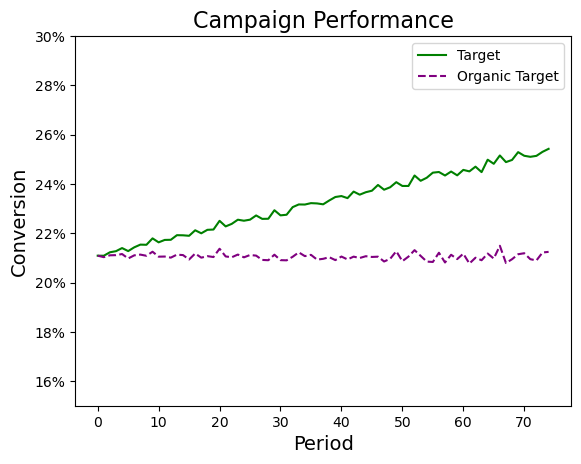

In [23]:
#plt.xlim(0, steps)  # Set x-axis limits from 0 to 4
plt.ylim(0.15, 0.3)  # Set y-axis limits from 3 to 7

#plot individual lines with custom colors, styles, and widths
plt.plot(final_results['Performance on All Target'], label='Target', color='green')
plt.plot(final_results['Performance on Organic Target'], label='Organic Target', color='purple', linestyle='dashed')

#add legend
plt.legend()

#add axis labels and a title
plt.ylabel('Conversion', fontsize=14)
plt.xlabel('Period', fontsize=14)
plt.title('Campaign Performance', fontsize=16)

plt.gca().set_yticklabels([f'{x:.0%}' for x in plt.gca().get_yticks()]) 

#display plot
plt.show()


In [ ]:
pd_weights = mab.get_pd_weights_long(segments=segments)

df=Segment_df 
seg_cols=seg_cols 
segments=segments 
print_diagnostics=True

variant_names = [
            'Control',
            'Variant A',
            'Variant B',
            'Variant C',
            ]    

if assign_variant:

    ## Full random assignment for Variant
    df['Rand_08'] = np.random.uniform(1, 100, len(df))

    variant_condition = [
            (df['Rand_08'] <= 5),
            (df['Rand_08'] > 5) & (df['Rand_08'] <= 37),
            (df['Rand_08'] > 37) & (df['Rand_08'] <= 69),
            (df['Rand_08'] > 69)
        ]

    df['variant_assignment'] = np.select(variant_condition, variant_names, default='Unknown')
    
## Loop through column
for col in seg_cols:
    cur_pd_weights = pd_weights
    cur_pd_weights['seg_names'] = cur_pd_weights.index
    df = df.merge(cur_pd_weights, how='left', left_on = [col,'variant_assignment'], right_on = ['seg_names','variant'], suffixes = (None, "_" + col))
            
cols_with_weights = [col for col in df.columns if 'weight' in col]
df['final_weight'] = df[cols_with_weights].mean(axis=1)

df['converted'] = df.apply(lambda row: np.random.choice([1,0], p=[row['final_weight'], 1 - row['final_weight']]), axis=1)

if print_diagnostics:
    df['was_modified'] = df['variant_assignment'] != 'Control'
    modified_ratios = df.groupby('was_modified').agg({'converted': ['mean', 'count', 'sum']})
    display(modified_ratios)

cols_to_return = seg_cols + ['variant_assignment', 'final_weight', 'converted']

return df[cols_to_return]